In [1]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
from MSMRD.trajectories import allTrajs
%matplotlib inline

In [9]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.0
        self.bathRad = 2.0
        self.bathRadOut = 2.0
        self.angularPartitions = 15
        self.Ncenters = len(self.centers)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    def getState(self, coord, prevst):
        radius = np.linalg.norm(coord)
        # inner MSM
        if radius < self.innerMSMrad:
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            return prevst
        # Entry states 
        elif radius < self.entryRad:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + angularState
        # Exit states 
        elif radius < self.bathRad:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + self.angularPartitions + angularState
        # Bath state
        elif radius < self.bathRadOut:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + 2*self.angularPartitions + angularState
    
        
    # Overwrite getMilestones function
    def getMilestones(self):
        int_th = 2*np.pi/self.angularPartitions
        # inner MSM
        for i in range(self.Ncenters):
            self.milestones[i] = self.centers[i]
        # entry states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters;
            r = 0.5*(self.innerMSMrad + self.entryRad)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # exit states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + self.angularPartitions;
            r = 0.5*(self.entryRad + self.bathRad)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
                # entry states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + 2*self.angularPartitions;
            r = 0.5*(self.bathRad + self.bathRadOut)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(self.Ncenters):
            statename = 'Inner state ' + str(i)
            self.regionMap[i] = statename
        for i in range(self.angularPartitions):
            statename = 'Entry state ' + str(i)
            j = self.Ncenters + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Exit state ' + str(i)
            j = self.Ncenters + self.angularPartitions + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Bath state ' + str(i)
            j = self.Ncenters + 2*self.angularPartitions + i
            self.regionMap[j] = statename


In [10]:
numfiles = 16
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/2DasymTrajsLong_smallR_'
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
alltrajs = asym2Dtraj(minima, []) # define allTrajs object
#alltrajs = allTrajs_inner([])
dimension = 2
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    traj = data[:,1:dimension+1]
    alltrajs.Trajs.append(traj)

In [11]:
# Calculate discrete trajectories and make sure it is clean (no "None" elements)
dtrajs = alltrajs.getdTrajsclean()
# Obtain centers of each state and save
centersdict = alltrajs.getMilestones()
centers = alltrajs.getMilestonesArray()

In [12]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(dtrajs, lags = 10)

estimating MaximumLikelihoodMSM: 100% (5/5) [######################] eta 00:01 |

(array([ -200.,     0.,   200.,   400.,   600.,   800.,  1000.,  1200.]),
 <a list of 8 Text yticklabel objects>)

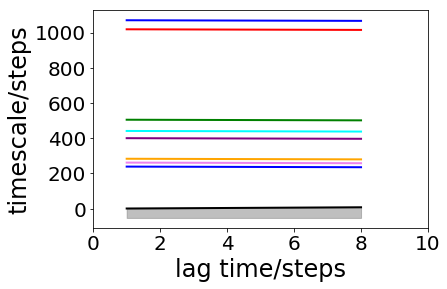

In [13]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
plt.xlim(0,10)
#plt.ylim(100,100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

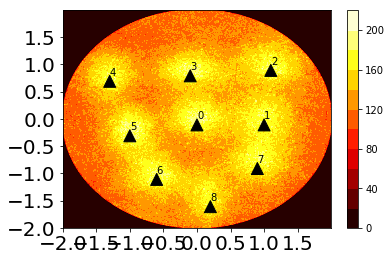

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111)
MSMradius = 2.0
X = np.arange(-MSMradius, MSMradius, 0.01)
Y = np.arange(-MSMradius, MSMradius, 0.01)
Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
for traj in alltrajs.Trajs:
    hist = np.histogram2d(traj[:,1], traj[:,0], bins = [X, Y], normed=False)
    Zfull += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = ax.contourf(Zfull, 10, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.colorbar(cp)
for i in range(len(minima)):
    ax.annotate(i, xy=minima[i], xytext=minima[i],
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

In [17]:
# Choose lag time and obtain MSM "M" for our milestones
msm_lag = 50
M = pyemma.msm.estimate_markov_model(dtrajs, msm_lag, reversible=False)

In [18]:
milestoningCKtest = M.cktest(4)

ValueError: Cannot compute PCCA for non-reversible matrices. Set reversible=True when constructing the MSM.

In [19]:
mfpt = np.zeros((len(minima), len(minima)))
timestep = 0.001
for i in range(len(minima)):
    for j in range(len(minima)):
        mfpt[i,j] = M.mfpt(i,j)*timestep

In [16]:
mfpt_lag1 = mfpt

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


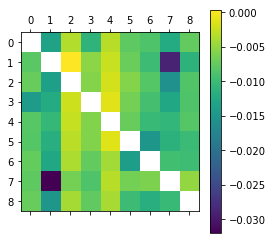

In [23]:
plt.matshow((mfpt_lag1-mfpt)/mfpt_lag1)
plt.colorbar()

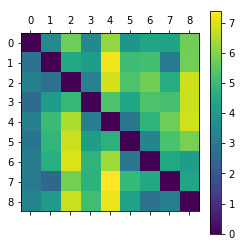

In [101]:
plt.matshow(mfpt)
plt.colorbar()

In [47]:
import pickle
pickle.dump(mfpt, open('2DasymMTT_inner_fromT_lag1.p', 'wa'))

(<matplotlib.figure.Figure at 0x7fb8c4102d10>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8bc75ce90>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7fb8bb3f8250>]], dtype=object))

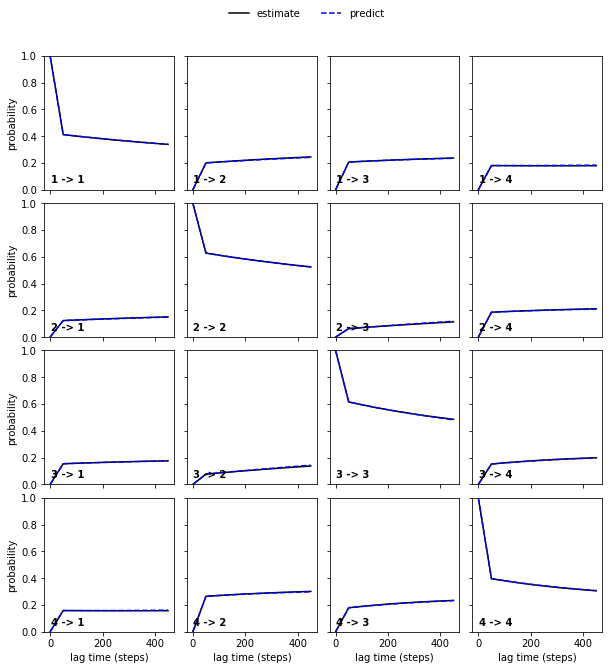

In [11]:
mplt.plot_cktest(milestoningCKtest)

ValueError: Invalid RGBA argument: 0.0021604384300435704

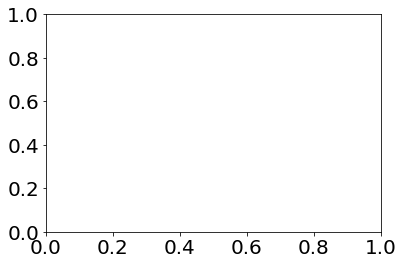

In [25]:
# Plot states and color them according to their weight in a given eigenmode
eigenmode = 1 # 0 = stationary distribution
vectors = M.eigenvectors_left()
value = M.eigenvalues()
#print M.timescales()[:10] 
#print -msm_lag/np.log(value[1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sc = plt.scatter(centers[:,0], centers[:,1], c=vectors[eigenmode], cmap=plt.cm.inferno, linewidths = 0, s=100)
plt.colorbar()
plt.clim(-0.05,0.05)

In [26]:
print M.eigenvectors_left()[1]

[ 0.00216044  0.12192575  0.20536375  0.02938123 -0.14345827 -0.13938816
 -0.11202154  0.06924162 -0.03320483]


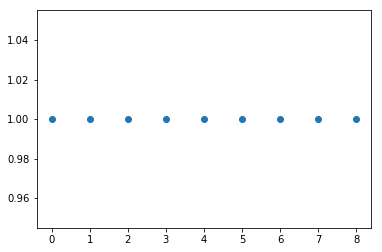

In [14]:
# Plot transition probabilities to bath state
T = M.transition_matrix
plt.plot(np.sum(T[:,-15:],axis=1), 'o')

In [28]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['interactionRadius'] = alltrajs.innerMSMrad
parameters['entryRadius'] = alltrajs.entryRad
parameters['bathRadius'] = alltrajs.bathRad
parameters['outerBathRadius'] = alltrajs.bathRadOut
parameters['NCenters'] = alltrajs.Ncenters
parameters['NangularPartitions'] = alltrajs.angularPartitions
parameters['lagtime'] = 50
model = MSMmodel(T, minima, parameters)

In [29]:
import pickle
pickle.dump(model, open('../data/asym2D_inner_lag50.p', 'wb'))

In [16]:
T.shape

(54, 54)

In [24]:
def computeMeanTransitionTimes(dTrajs, timestep, Nstates):
    sumTau = np.zeros((Nstates, Nstates))
    counts = np.zeros((Nstates, Nstates))
    for dTraj in dTrajs:
        i = 0
        tau = 0
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            tau += 1
            if dTraj[i] != dTraj[i-1]:
                if len(statesVisited) == Nstates:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 0
                elif not np.in1d(dTraj[i], statesVisited):
                    sumTau[transitionFrom, dTraj[i]] += tau
                    counts[transitionFrom, dTraj[i]] += 1
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    statesVisited.append(dTraj[i])
    meanTransitionTimes = np.zeros((Nstates, Nstates))
    for i in range(0, Nstates):
        for j in range(0, Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [25]:
def computeMeanTransitionTimesFullTraj(dTrajs, timestep, Nstates):
    sumTau = np.zeros((Nstates, Nstates))
    counts = np.zeros((Nstates, Nstates))
    for dTraj in dTrajs:
        i = 0
        tau = 0
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        for i in range(len(dTraj)):
            tau = 0
            j = i
            searchOn = True
            statesVisited = [dTraj[i]]
            while searchOn:
                j += 1
                tau += 1
                if j >= len(dTraj-1):
                    searchOn = False
                elif dTraj[j] != dTraj[j-1]:
                    if len(statesVisited) == Nstates:
                        searchOn = False
                    elif not np.in1d(dTraj[i], statesVisited):
                        sumTau[dTraj[i], dTraj[j]] += tau
                        counts[dTraj[i], dTraj[j]] += 1
                        statesVisited.append(dTraj[j])
    meanTransitionTimes = np.zeros((Nstates, Nstates))
    for i in range(0, Nstates):
        for j in range(0, Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [26]:
def computeMeanTransitionTimesFull(dTrajs, timestep, Nstates):
    sumTau = np.zeros((Nstates, Nstates))
    counts = np.zeros((Nstates, Nstates))
    for dTraj in dTrajs:
        i = 0
        tau = 0
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        prevTransitionIndex = i
        while i<len(dTraj)-1:
            i += 1
            tau += 1
            if dTraj[i] != dTraj[i-1]:
                if len(statesVisited) == Nstates:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    prevTransitionIndex = nextTransitionIndex
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 0
                elif not np.in1d(dTraj[i], statesVisited):
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    transitionTime = nextTransitionIndex - prevTransitionIndex
                    for time in range(transitionTime):
                        sumTau[transitionFrom, dTraj[i]] += tau-time
                        counts[transitionFrom, dTraj[i]] += 1
                    statesVisited.append(dTraj[i])
    meanTransitionTimes = np.zeros((Nstates, Nstates))
    for i in range(0, Nstates):
        for j in range(0, Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [27]:
def computeMeanTransitionTimesTrivial(dTrajs, timestep, Nstates):
    sumTau = np.zeros((Nstates, Nstates))
    counts = np.zeros((Nstates, Nstates))
    for dTraj in dTrajs:
        for i in range(len(dTraj)):
            for state in range(Nstates):
                if dTraj[i] == state:
                    continue
                j = 0
                searchOn = True
                while searchOn:
                    j+=1
                    if i+j >= len(dTraj) - 1:
                        searchOn = False
                    elif dTraj[i+j] == state:
                        searchOn = False
                        sumTau[dTraj[i], state] += j
                        counts[dTraj[i], state] += 1
    meanTransitionTimes = np.zeros((Nstates, Nstates))
    for i in range(0, Nstates):
        for j in range(0, Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [ ]:
MTT = computeMeanTransitionTimes(dtrajs, 0.001, len(minima))

In [83]:
MTTF = computeMeanTransitionTimesFull(dtrajs, 0.001, len(minima))

In [119]:
MTTT = computeMeanTransitionTimesTrivial([dtrajs[0]], 0.001, len(minima))

In [134]:
stridedDTrajs = []
for traj in dtrajs:
    stridedTraj = traj[::50]
    stridedDTrajs.append(stridedTraj)

In [135]:
MTTstrided = computeMeanTransitionTimes(stridedDTrajs, 0.05, len(minima))

In [150]:
MTTFullTraj = computeMeanTransitionTimesFullTraj(dtrajs, 0.001, len(minima))

KeyboardInterrupt: 

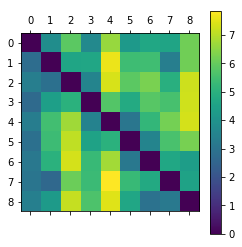

In [145]:
plt.matshow(MTTstrided-)
plt.colorbar()

0.0482872879371


/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


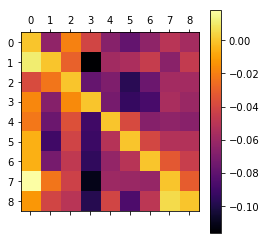

In [160]:
diff = (mfpt-MTTstrided)/mfpt
diff[np.isnan(diff)] = 0
plt.matshow(diff, cmap=plt.cm.inferno)
plt.colorbar()
print np.mean(abs(diff))

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


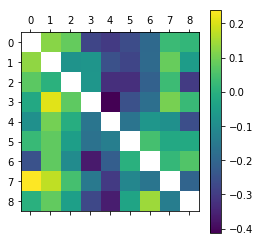

In [122]:
plt.matshow((MTTT-MTTF)/MTTT)
plt.colorbar()

In [65]:
BDtransitionTimes = pickle.load(open('2DasymMTT_inner.p'))

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


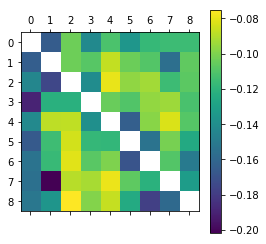

In [67]:
plt.matshow((MTT-BDtransitionTimes)/BDtransitionTimes)
plt.colorbar()

In [77]:
for i in range(0):
    print i